In [ ]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gradio as gr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score

In [42]:
#Load the dataset
def load_dataset():
    return pd.read_csv('covtype.csv')

#This function is going to provide information about the dataset like the shape of dataframe, the name of columns,
#the number of unique values in each column, number of the null values in each column, 
#and its descriptive statistics like count, mean and standard deviation
def get_df_info(df):
    print("\n\033[1mShape of DataFrame:\033[0m ", df.shape)
    print("\n\033[1mColumns in DataFrame:\033[0m ", df.columns.to_list())
    print("\n\033[1mNumber of unique values in each column:\033[0m")
    for col in df.columns:
        print(f"\033[1m{col}\033[0m: {df[col].nunique()}")     
    print("\n\033[1mNumber of null values in each column:\033[0m\n", df.isnull().sum())
    print("\n\033[1mDescriptive statistics of DataFrame:\033[0m\n", df.describe().transpose())

In [43]:
#Remove outliers to clean up the dataset. This is performed to remove the extreme data which helps
#in optimizing the performance.
def remove_outliers(df, numerical_features):
    Q1 = df[numerical_features].quantile(0.25)
    Q3 = df[numerical_features].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Create a mask based on numerical features
    mask = ~((df[numerical_features] < lower_bound) | 
             (df[numerical_features] > upper_bound)).any(axis=1)
    
    # Apply the mask to the entire DataFrame
    df_cleaned = df[mask]
    
    return df_cleaned

In [ ]:
#PreProcessing
#Load Dataframe
df = load_dataset()

#Print the dataframe information
get_df_info(df)

#Make a list of numerical fearures
numerical_features = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

#Remove outliers
df_cleaned = remove_outliers(df, numerical_features)

# Separate features and target
X = df_cleaned.drop('Cover_Type', axis=1)
Y = df_cleaned['Cover_Type']

#Split the data into 80% training set and 20% testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)


In [ ]:
#Before scaling plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=pd.DataFrame(X_train,columns=numerical_features))
plt.title('Before Scaling')
plt.xticks(rotation=90)

# Ensure X_train and X_test are DataFrames
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Standardize numerical features
scaler = StandardScaler()

# Scale numerical features
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numerical_features]), 
                              columns=numerical_features, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numerical_features]), 
                             columns=numerical_features, index=X_test.index)

# Update X_train and X_test
X_train.update(X_train_scaled)
X_test.update(X_test_scaled)

# After scaling Plot
plt.subplot(1, 2, 2)
sns.boxplot(data=pd.DataFrame(X_train,columns=numerical_features))
plt.title('After StandardScaler')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Feature Importance Table:
                               Feature  Importance
0                            Elevation    0.290925
1      Horizontal_Distance_To_Roadways    0.140486
2   Horizontal_Distance_To_Fire_Points    0.128195
3     Horizontal_Distance_To_Hydrology    0.064699
4       Vertical_Distance_To_Hydrology    0.058227
5                               Aspect    0.048372
6                       Hillshade_Noon    0.044748
8                        Hillshade_9am    0.039748
7                        Hillshade_3pm    0.039733
9                                Slope    0.030402
10                    Wilderness_Area4    0.021883
16                    Wilderness_Area3    0.020709
11                         Soil_Type22    0.018678
12                          Soil_Type4    0.015793
14                         Soil_Type23    0.014890
13                          Soil_Type2    0.012374
15                         Soil_Type38    0.010137


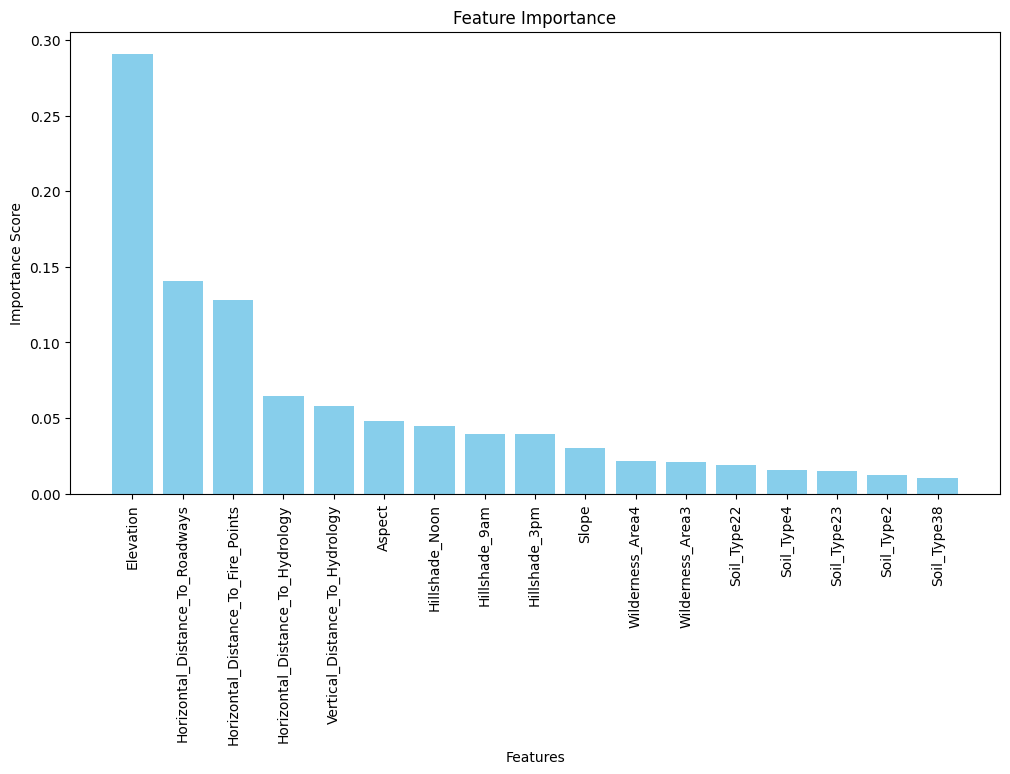


Selected Features based on Importance Threshold:
['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Aspect', 'Hillshade_Noon', 'Hillshade_9am', 'Hillshade_3pm', 'Slope', 'Wilderness_Area4', 'Wilderness_Area3', 'Soil_Type22', 'Soil_Type4', 'Soil_Type23', 'Soil_Type2', 'Soil_Type38']

Final Dataset Shape (Training Set): (378138, 17)

Final Dataset Shape (Test Set): (94535, 17)


In [46]:
 
# Train Random Forest and Extract Feature Importance
rf_features = RandomForestClassifier(random_state=42)  # Initialize Random Forest
rf_features.fit(X_train, Y_train)  # Train the model on the training set
 
# Get feature importance
feature_importances = rf_features.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
 
print("\nFeature Importance Table:")
print(importance_df)
 
# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xticks(rotation=90)
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

 
#  Apply Importance Thresholds
# Define thresholds
importance_threshold = 0.01  # Set minimum importance score to retain a feature

 
# Retain features based on importance
selected_features = importance_df[importance_df['Importance'] > importance_threshold]['Feature'].tolist()
print("\nSelected Features based on Importance Threshold:")
print(selected_features)
 
 
# Update the Dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]
print("\nFinal Dataset Shape (Training Set):", X_train.shape)
print("\nFinal Dataset Shape (Test Set):", X_test.shape)

Accuracy: 0.9553287142328238

Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.95      0.96     36642
           2       0.95      0.97      0.96     46537
           3       0.95      0.94      0.94      4145
           4       0.91      0.77      0.84       152
           5       0.95      0.75      0.84      1537
           6       0.92      0.90      0.91      2359
           7       0.98      0.94      0.96      3163

    accuracy                           0.96     94535
   macro avg       0.94      0.89      0.91     94535
weighted avg       0.96      0.96      0.96     94535



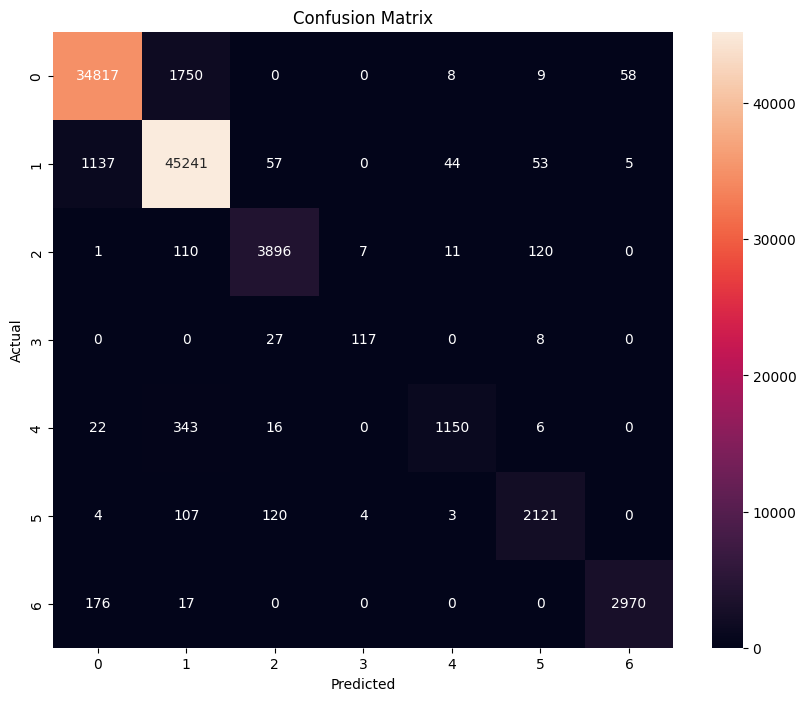

In [39]:
# Initialize and train model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, Y_train)

# Make predictions
Y_pred = rf.predict(X_test)

# Evaluate model
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))

# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [47]:
# Perform 5-fold cross validation
cv_scores = cross_val_score(rf, X_train, Y_train, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))
print("Standard deviation:", np.std(cv_scores))

Cross-validation scores: [0.94705665 0.94955572 0.94736077 0.9446494  0.94796832]
Mean CV accuracy: 0.9473181695078964
Standard deviation: 0.0015888283791508026


In [ ]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
rf = grid_search.best_estimator_

# Cross-validation
cv_scores = cross_val_score(rf, X_train, Y_train, cv=5, scoring='accuracy')
print("Mean CV Accuracy:", np.mean(cv_scores))

# Train and Predict
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [48]:
# Function for prediction 
def predict_forest_cover(*args):
    user_input = np.array(args).reshape(1, -1)
    
    # Predict
    prediction = rf.predict(user_input)  # Assume 'rf' is trained
    return f"Predicted Cover Type: {int(prediction[0])}"

# Updated Gradio interface
exclude_column = 'Cover_Type'
inputs = [
    gr.Number(label=column) for column in df.columns.to_list() if column != exclude_column
]

output = gr.Textbox(label="Predicted Forest Cover Type")

app = gr.Interface(fn=predict_forest_cover, inputs=inputs, outputs=output)
app.launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
